In [2]:
# TODO: manage imports
library(eurostat)
library(ggplot2)
library(gridExtra)
library(cowplot)
library(repr)
library(vtable)
library(tidyr)
library(tibble)

Loading required package: kableExtra



In [3]:
dark_grey <- '#555555'

In [4]:
K <- 27
L <- nchar('bardatskii')
M <- ((K + L) * 47) %% 11 + 1
data.frame(
    country=c('ČR', 'Norsko', 'Rakousko', 'Belgie', 'Řecko', 'Španělsko', 
              'Nizozemsko', 'Portugalsko', 'Švýcarsko	', 'Finsko', 'Irsko'),
    examiner=c(rep('K. Dedecius', 6), rep('P. Novák', 5))
)[M,]

,country,examiner
,<chr>,<chr>
2,Norsko,K. Dedecius


In [5]:
dataset <- get_eurostat(id='crim_gen_reg')

Table crim_gen_reg cached at /tmp/RtmpMHD1XX/eurostat/7bf3827eef6bbcfb13824e254af9ce0d.rds



In [6]:
str(dataset)

tibble [216,947 × 6] (S3: tbl_df/tbl/data.frame)
 $ freq       : chr [1:216947] "A" "A" "A" "A" ...
 $ unit       : chr [1:216947] "NR" "NR" "NR" "NR" ...
 $ iccs       : chr [1:216947] "ICCS0101" "ICCS0101" "ICCS0101" "ICCS0101" ...
 $ geo        : chr [1:216947] "AL" "AL" "AL" "AL" ...
 $ TIME_PERIOD: Date[1:216947], format: "2008-01-01" "2009-01-01" ...
 $ values     : num [1:216947] 88 82 118 124 126 107 98 54 71 52 ...


In [7]:
unique(dataset$TIME_PERIOD)

[1] "2008-01-01" "2009-01-01" "2010-01-01" "2011-01-01" "2012-01-01"
 [6] "2013-01-01" "2014-01-01" "2015-01-01" "2016-01-01" "2017-01-01"
[11] "2018-01-01" "2019-01-01" "2020-01-01" "2021-01-01"

In [8]:
data <- subset(dataset, 
               startsWith(geo, 'NO') &
               nchar(geo) == 5 &
               TIME_PERIOD == '2021-01-01', 
               c(unit, iccs, geo, values))
prev_labels <- c('ICCS0101', 'ICCS0401', 'ICCS0502', 'ICCS050211')
new_labels <- c('Int. homicide', 'Robbery', 'Other theft', 'Vehicle theft')
data$iccs <- factor(data$iccs, levels=prev_labels, labels=new_labels)

In [9]:
data_by_unit <- split(data[, -1], data$unit)
all.equal(data_by_unit$P_HTHAB[, 1:2], data_by_unit$NR[, 1:2])

[1] TRUE

In [10]:
data <- merge(x=data_by_unit$P_HTHAB, y=data_by_unit$NR, by=c('iccs', 'geo'), all=T)  # outer join
colnames(data)[3] <- 'rel'
colnames(data)[4] <- 'abs'

In [11]:
any(is.na(data))

[1] FALSE

In [12]:
freq_df <- pivot_wider(data[, -4], names_from=iccs, values_from=rel)
freq_df[, 'Other theft'] <- freq_df[, 'Other theft'] - freq_df[, 'Vehicle theft']  # TODO: comment above + ref here
freq_table <- (freq_df %>% column_to_rownames('geo') %>% as.matrix() %>% as.table())
names(dimnames(freq_table)) <- c('geo', 'iccs')

In [13]:
freq_df

geo,Int. homicide,Other theft,Robbery,Vehicle theft
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
NO020,0.00,788.98,5.13,32.92
NO060,0.21,1320.46,8.91,62.40
NO071,0.00,583.33,1.66,37.03
NO074,0.00,731.72,5.78,43.77
NO081,1.00,2942.85,46.91,74.32
NO082,1.04,1240.03,10.46,54.62
NO091,0.47,1359.86,10.43,91.97
NO092,0.32,1680.79,12.95,112.35
NO0A1,0.00,1389.22,11.40,55.53


In [14]:
# TODO: attention: "data" variable contains incorrect theft values, do not use it below without additional preprocessing

In [15]:
prob_table.row_cond <- prop.table(freq_table, margin=1)
prob_table.col_cond <- prop.table(freq_table, margin=2)

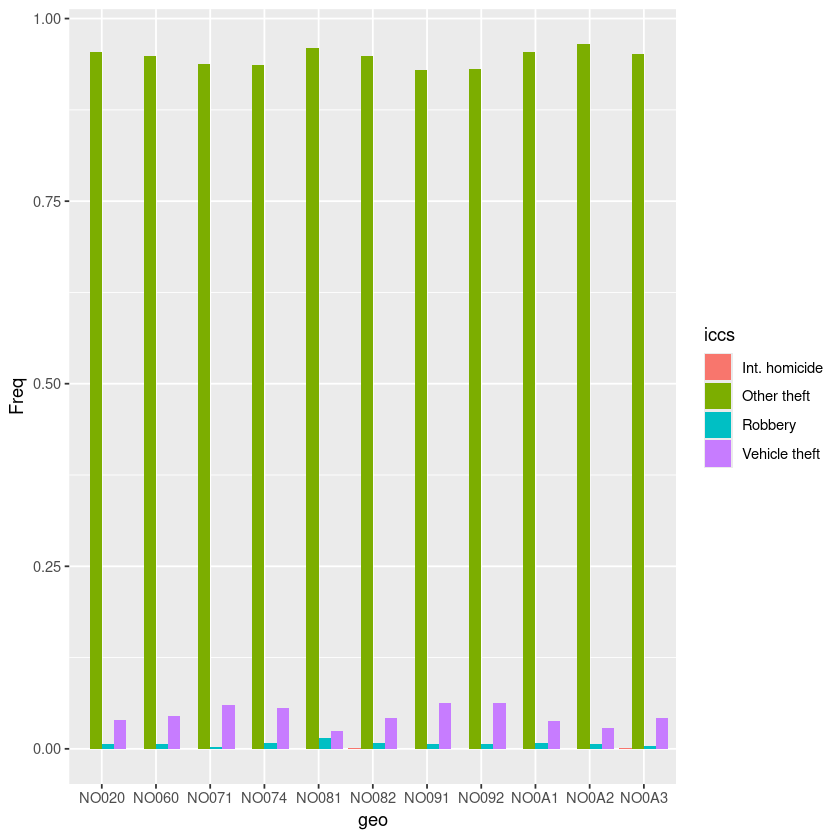

In [16]:
# TODO: rename axes
ggplot(as.data.frame(prob_table.row_cond), aes(x=geo, y=Freq, fill=iccs)) +
    geom_bar(stat='identity', position='dodge')

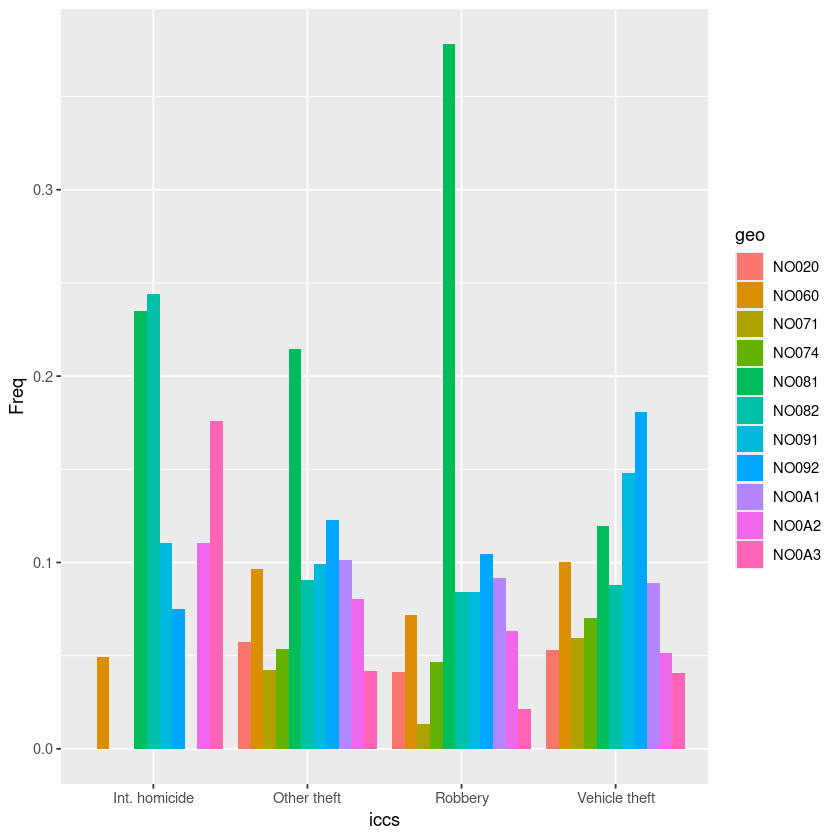

In [17]:
# TODO: rename axes
ggplot(as.data.frame(prob_table.col_cond), aes(x=iccs, y=Freq, fill=geo)) +
    geom_bar(stat='identity', position='dodge')

## Test #2 (2008 vs 2019)

### Intuition

This part will examine whether there is a relationship between the number of crimes and time. First, let us consider the intuition why such a test might have meaning.

For this task, we will choose capital region data between $2008$ and $2019$. The regional division was changed after $2019$, so we cannot consider the more recent data along with the older ones, which is simply a larger number. Additionally, in this case, it makes sense to consider absolute values, since this is the same region and its population has not changed much over this period of time.

In [18]:
crime_dynamics <- subset(dataset,
                         geo == 'NO011' & unit == 'NR',
                         c(iccs, TIME_PERIOD, values))
crime_dynamics <- pivot_wider(crime_dynamics, names_from=iccs, values_from=values)
crime_dynamics$ICCS0502 <- crime_dynamics$ICCS0502 - crime_dynamics$ICCS050211  # solution of the same problem with subset
all(colnames(crime_dynamics)[-1] == prev_labels)  # justification for the following line of code
colnames(crime_dynamics)[-1] <- new_labels

[1] TRUE

In [19]:
crime_dynamics

TIME_PERIOD,Int. homicide,Robbery,Other theft,Vehicle theft
<date>,<dbl>,<dbl>,<dbl>,<dbl>
2008-01-01,12,928,39529,2506
2009-01-01,7,1048,41836,2527
2010-01-01,5,958,40755,2161
2011-01-01,19,932,43665,1967
2012-01-01,8,842,47997,1436
2013-01-01,8,961,40261,1254
2014-01-01,7,524,32200,1094
2015-01-01,12,437,28183,895
2016-01-01,4,364,25167,759


As can be seen from the dataframe above there is a downward trend in crime. The following visualization demonstrates this better.

Warning message:
“Using an external vector in selections was deprecated in tidyselect 1.1.0.
ℹ Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(new_labels)

  # Now:
  data %>% select(all_of(new_labels))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.”


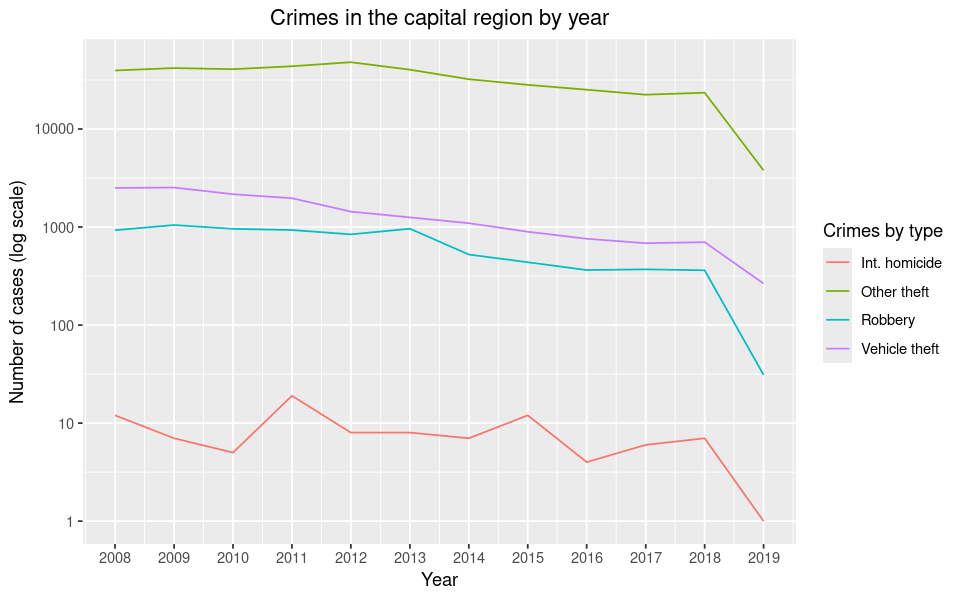

In [20]:
options(repr.plot.width=8, repr.plot.height=5)
ggplot(crime_dynamics %>% pivot_longer(cols=new_labels,
                                       names_to='crime',
                                       values_to='values'),
       aes(x=TIME_PERIOD, y=values, color=crime)) +
    geom_line() +
    scale_x_date(breaks=crime_dynamics$TIME_PERIOD, date_labels='%Y') +
    scale_y_continuous(trans='log10') +
    labs(title='Crimes in the capital region by year',
         x='Year',
         y='Number of cases (log scale)',
         color='Crimes by type') +
    theme(plot.title=element_text(hjust=0.5))

Special attention should be paid to the fact that the y-axis has log scaling. The changes over time are actually impressive. This is confirmed by further examination of $2008$ and $2019$ separately.

In [21]:
freq_time_vs_crime_df <- subset(crime_dynamics, TIME_PERIOD %in% c('2008-01-01', '2019-01-01'))
freq_time_vs_crime_table <- (freq_time_vs_crime_df %>% column_to_rownames('TIME_PERIOD') %>% as.matrix() %>% as.table())
names(dimnames(freq_time_vs_crime_table)) <- c('year', 'crime')

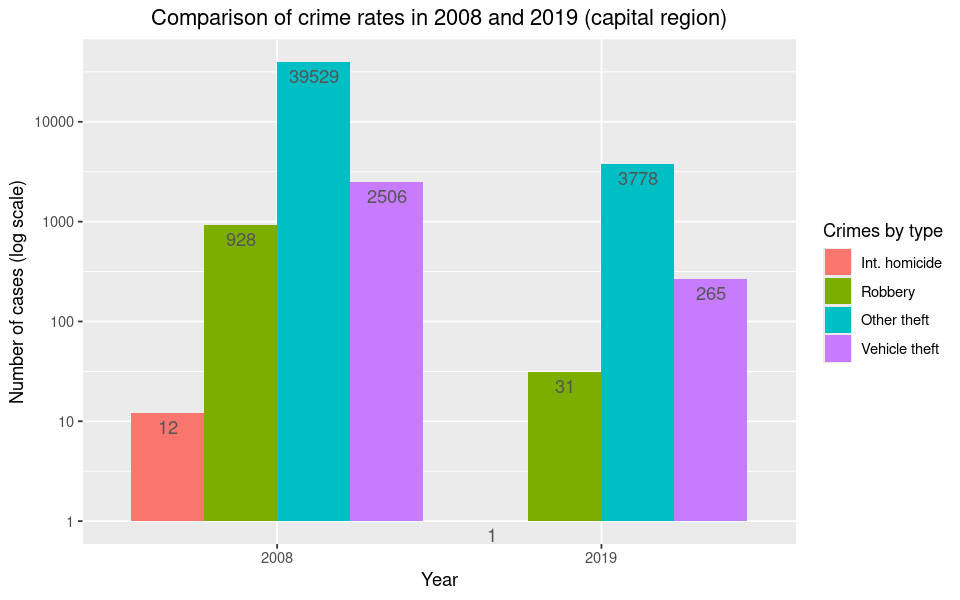

In [22]:
ggplot(as.data.frame(freq_time_vs_crime_table), aes(x=year, y=Freq, fill=crime)) +
    geom_bar(stat='identity', position='dodge') +
    scale_x_discrete(labels=format(freq_time_vs_crime_df$TIME_PERIOD, '%Y')) +
    scale_y_continuous(trans='log10') +
    labs(title='Comparison of crime rates in 2008 and 2019 (capital region)',
         x='Year',
         y='Number of cases (log scale)',
         fill='Crimes by type') +
    theme(plot.title=element_text(hjust=0.5)) +
    geom_text(aes(label=Freq), position=position_dodge(.9), vjust=1.5, color=dark_grey)

The number of cases has decreased by times. Let's check the statistical significance of these changes.

### Statistical significance

In this instance, the existence of independence between the two variables **year** and **crime** is investigated. Both are qualitative, so it makes sense to look at the contingency table `freq_time_vs_crime_table` to select a statistical test.

In [32]:
freq_time_vs_crime_table

            crime
year         Int. homicide Robbery Other theft Vehicle theft
  2008-01-01            12     928       39529          2506
  2019-01-01             1      31        3778           265

Let's start by defining the matrix of **observed** frequencies $\mathbf O \in \mathbb N^{2,4}$ (`freq_time_vs_crime_table`) and the matrix of **expected** frequencies $\mathbf E \in \mathbb N^{2,4}$ as follows$$(\forall i \in \hat n)(\forall j \in \hat m)\left(\mathbf E_{ij} = \frac{f_{i.} \cdot f_{.j}}{N}\right),$$where $n=2, m=4$ and the expression on the right denotes dividing the **marginal frequencies** by the total number of observations. Then the hypotheses will look as follows$$\begin{align*} H_0: \ \mathbf O = \mathbf E  && \text{(variables are independent)} \\ H_A: \ \mathbf O \ne \mathbf E \end{align*}$$The expressions above can be given an analogue in probabilities.

In [33]:
chisq.test(freq_time_vs_crime_table)$expected  # TODO

Warning message in chisq.test(freq_time_vs_crime_table):
“Chi-squared approximation may be incorrect”


,Int. homicide,Robbery,Other theft,Vehicle theft
2008-01-01,11.87407,875.94102,39556.181,2531.0037
2019-01-01,1.12593,83.05898,3750.819,239.9963


In [30]:
fisher.test(freq_time_vs_crime_table, alternative='only in the 2x2 case', simulate.p.value=T)


	Fisher's Exact Test for Count Data with simulated p-value (based on
	2000 replicates)

data:  freq_time_vs_crime_table
p-value = 0.0004998
alternative hypothesis: only in the 2x2 case


## Test #3 (Norway vs Finland)

In [65]:
freq_no_vs_fi_crime_df <- subset(dataset,
                                 geo %in% c('NO', 'FI') &
                                 iccs %in% prev_labels[-4] &
                                 TIME_PERIOD == '2021-01-01' &
                                 unit == 'NR',
                                 c(geo, iccs, values))
freq_no_vs_fi_crime_df <- pivot_wider(freq_no_vs_fi_crime_df, names_from=iccs, values_from=values)
colnames(freq_no_vs_fi_crime_df)[-1] <- c('Int. homicide', 'Robbery', 'Theft')

In [66]:
freq_no_vs_fi_crime_table <- (freq_no_vs_fi_crime_df %>% column_to_rownames('geo') %>% as.matrix() %>% as.table())
names(dimnames(freq_no_vs_fi_crime_table)) <- c('country', 'crime')

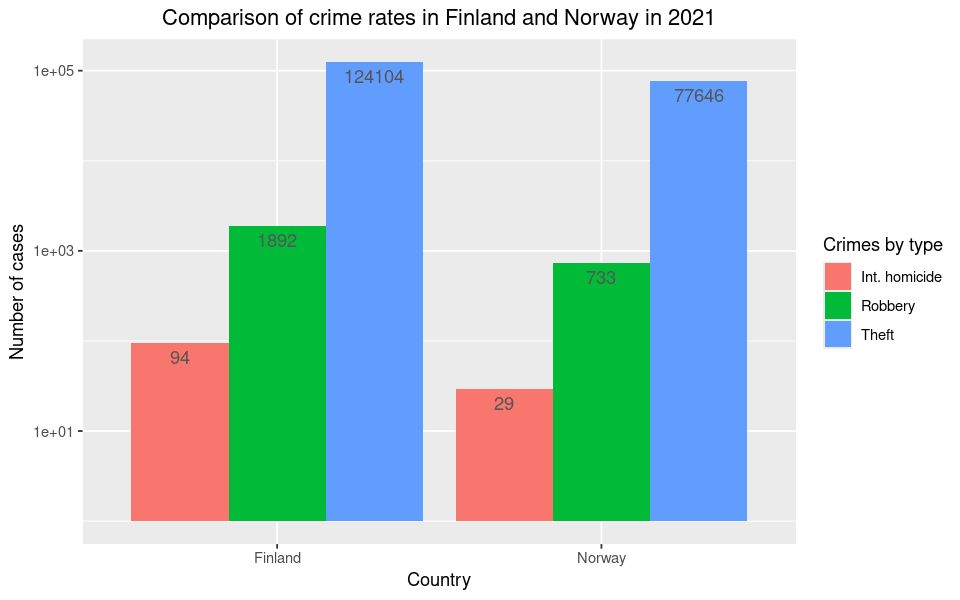

In [67]:
ggplot(as.data.frame(freq_no_vs_fi_crime_table), aes(x=country, y=Freq, fill=crime)) +
    geom_bar(stat='identity', position='dodge') +
    scale_x_discrete(labels=c('Finland', 'Norway')) +
    scale_y_continuous(trans='log10') +
    labs(title='Comparison of crime rates in Finland and Norway in 2021',
         x='Country',
         y='Number of cases (log scale)',
         fill='Crimes by type') +
    theme(plot.title = element_text(hjust=0.5)) +
    geom_text(aes(label=Freq), position=position_dodge(.9), vjust=1.5, color=dark_grey)

In [72]:
chisq.test(freq_no_vs_fi_crime_table)


	Pearson's Chi-squared test

data:  freq_no_vs_fi_crime_table
X-squared = 133.64, df = 2, p-value < 2.2e-16
